In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [2]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution# , plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std, plot_IP_iteration_std
from sklearn.metrics import mean_squared_error

In [3]:
def enkf_linear_inverse_problem(setting_dict,
                                analysis_dict
                                ):

    """ Ensemble Kalman Filter algorithm applied to an inverse problem.


    Parameters:

    setting_dict (dict): Dictionary containing
        model_func (function): Function to apply to x.
        x (np.array): True parameters.
        y (np.array): True target variable.
        particles (int): Number of particles in the ensemble.
        iterations (int): Number of iterations.
        noise (bool): Whether or not to add noise to the target variable.
        std (np.array): Standard deviation of the noise.
        h_0 (int or float): Starting step size.
        epsilon (float): Constant for numerical stability in the step size.
        randomization (bool): Whether or not to add noise to the particles and randomize them around their mean.
        loss (str): Which kind of loss to use. Can be either "mse" or "rel_mse"


    Returns:

    final_params (np.ndarray): Final predicted parameter.
    loss_evolution (list): Evolution of the loss value over each iteration.
    loss_evolution_single_dict (dict): Evolutions of loss values of all particles.

    """

    A = setting_dict["A"]
    x = setting_dict["x"]
    y = setting_dict["y"]
    particles = setting_dict["particles"]
    iterations = setting_dict["iterations"]
    batch_size = setting_dict["batch_size"]
    noise = setting_dict["noise"]
    std = setting_dict["std"]
    h_0 = setting_dict["h_0"]
    epsilon = setting_dict["epsilon"]
    randomization = setting_dict["randomization"]
    loss_type = setting_dict["loss"]
    
    batch_particle_connection = analysis_dict["batch_particle_connection"]["connect"]
    update_all = analysis_dict["batch_particle_connection"]["update_all"]

    if noise and any(std == None):
        raise ValueError("If noise is True, then std can not be None.")

    def loss(y_true, y_pred):
        if not noise:
            if loss_type == "mse":
                return mean_squared_error(y_true, y_pred)
            elif loss_type == "rel_mse":
                return mean_squared_error(y_true, y_pred) / np.mean(y_true)
        else:
            if loss_type == "mse":
                return np.mean(np.dot(np.sqrt(np.linalg.inv(np.diag(std))), y_true - y_pred)**2)
            elif loss_type == "rel_mse":
                return np.mean(np.dot(np.sqrt(np.linalg.inv(np.diag(std))), y_true - y_pred)**2) / np.mean(y_true)

    def grad_loss(y_true, y_pred):
        if not noise:
            return (-2) / y_true.shape[0] * (y_true - y_pred)
        else:
            return (-2) / y_true.shape[0] * np.diag(np.sqrt(np.linalg.inv(np.diag(std)))) * (y_true - y_pred)
        
    if batch_size is None:
        batch_size = A.shape[0]
    n = A.shape[0]
    num_batches = int(np.ceil(n / batch_size))
    batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
    batch_indices[-1] = n
    
    indices = np.arange(n)
    A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    
    if batch_particle_connection:
        batch_particle_dict = {}
        batch_particle_indices = np.arange(particles) + 1
        np.random.shuffle(batch_particle_indices)
        if particles == num_batches:
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
        elif particles > num_batches:
            base_batches = particles // num_batches
            add_batches = particles % num_batches
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                batch_particle_indices = batch_particle_indices[base_batches:]
            for i in range(add_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
        elif num_batches > particles:
            num_reps = int(np.ceil(num_batches / particles))
            particles_repeated = np.tile(batch_particle_indices, num_reps)
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
    else:
        batch_particle_dict = None
                
    param_dict = {}
    y_pred_dict = {}
    jacobian_dict = {}
    loss_dict = {}

    for i in range(particles):
        param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = loss(y, y_pred_dict["particle_{}".format(i+1)])

    param_mean = np.mean(list(param_dict.values()), axis = 0)

    loss_evolution = []
    loss_evolution.append(loss(y, np.dot(A, param_mean)))

    loss_evolution_single_dict = {}
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)] = [loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

    for iteration in range(iterations):
        for b in range(num_batches):
            batch_particles = []
            y_pred_batch_dict = {}
            jacobian_batch_dict = {}
            # update the predictions, jacobian and loss for the new parameters
            for i in range(particles):
                if batch_particle_connection: 
                    if num_batches == particles or num_batches > particles:
                        if batch_particle_dict["batch_{}".format(str(b+1))] != i+1:
                            continue
                    else:
                        if i+1 not in batch_particle_dict["batch_{}".format(str(b+1))]:
                            continue
                if batch_particle_connection:
                    batch_particles.append(i+1)
                    
                y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
                y_pred_batch_dict["particle_{}".format(i+1)] = y_pred_dict["particle_{}".format(i+1)]
                jacobian_dict["particle_{}".format(i+1)] = grad_loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)])
                jacobian_batch_dict["particle_{}".format(i+1)] = jacobian_dict["particle_{}".format(i+1)]
                loss_dict["particle_{}".format(i+1)] = loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

            # compute the mean of the predictions
            if batch_particle_connection:
                y_pred_mean = np.mean(list(y_pred_batch_dict.values()), axis = 0)
            else:
                y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

            # compute the matrix D elementwise
            if not batch_particle_connection:
                d = np.zeros(shape = (particles, particles))
                for k in range(particles):
                    y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
                    for j in range(particles):
                        d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
            else:
                d = np.zeros(shape = (len(y_pred_batch_dict), len(y_pred_batch_dict)))
                for k in range(len(y_pred_batch_dict)):
                    y_pred_centered = list(y_pred_batch_dict.values())[k] - y_pred_mean
                    for j in range(len(y_pred_batch_dict)):
                        d[k][j] = np.dot(y_pred_centered, list(jacobian_batch_dict.values())[j])
            d = np.transpose(d)

            # compute the scalar h_t
            h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

            # matrix with particle parameters as row vectors
            if not batch_particle_connection:
                params_all_ptcls = np.array(list(param_dict.values()))
            else:
                param_batch_dict = {}
                for i in range(len(batch_particles)):
                    param_batch_dict["particle_{}".format(batch_particles[i])] = param_dict["particle_{}".format(batch_particles[i])]
                    params_all_ptcls = np.array(list(param_batch_dict.values()))

            # compute the matrix with the updates for each particle
            params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)

            # write the updates back into the dictionary
            k = -1
            for i in range(particles):
                if batch_particle_connection:
                    if not update_all:
                        if i not in batch_particles:
                            continue
                        k += 1
                        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[k]
                else:
                    param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]

                if randomization:
                    # add randomization/ noise to each particle
                    stddev = 0.1
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = param_dict["particle_{}".format(str(i+1))].shape)
                    new_param = param_dict["particle_{}".format(str(i+1))] + noise
                    param_dict["particle_{}".format(str(i+1))] = new_param

            if randomization:
                # randomize particles around their mean
                param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
                for i in range(particles):
                    stddev = 0.1
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = param_dict["particle_{}".format(str(i+1))].shape)
                    new_params = param_dict_mean + noise
                    param_dict["particle_{}".format(str(i+1))] = new_params

        # compute loss for the parameter means
        param_mean = np.mean(params_all_ptcls, axis = 0)
        loss_evolution.append(loss(y, np.dot(A, param_mean)))

        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

    final_params = param_mean

    return final_params, loss_evolution, loss_evolution_single_dict, batch_particle_dict

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [4]:
A = np.random.uniform(size = (10000, 50))
x = np.random.uniform(size = (A.shape[1], ))

In [5]:
def model_func(x):
    return np.dot(A, x)

In [6]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [7]:
setting_dict = {"A": A,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 10,
                "batch_size" : 200,            
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False,
                "loss": "mse"
                }
analysis_dict = {"batch_particle_connection": {"connect": True,
                                               "update_all": False}}

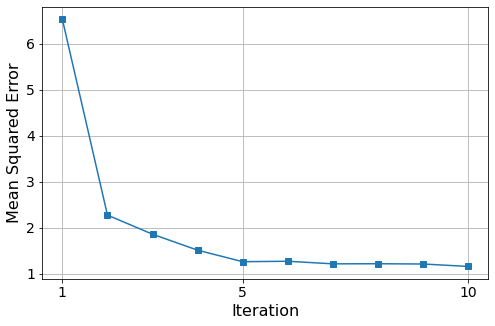

[6.530117023936876, 2.2757194298793553, 1.8601722719623628, 1.512803762640988, 1.2628523069918556, 1.272271578631813, 1.2160907521111797, 1.2183368460790023, 1.2125394553627866, 1.1595124121813032]

{'batch_1': array([136,  57, 100, 131]), 'batch_2': array([ 40,  94, 117,  85]), 'batch_3': array([ 99, 162,  53,   8]), 'batch_4': array([183,  21,  81, 113]), 'batch_5': array([185,  42,  66, 193]), 'batch_6': array([ 50, 192,  60,  73]), 'batch_7': array([76, 72, 74, 90]), 'batch_8': array([176, 102, 177, 119]), 'batch_9': array([141,  52, 118, 123]), 'batch_10': array([157, 165,  33, 132]), 'batch_11': array([191, 161,  96,  30]), 'batch_12': array([ 38, 129, 140,  62]), 'batch_13': array([178, 160, 200, 111]), 'batch_14': array([  4, 151,  22,  15]), 'batch_15': array([ 43,   2,  67, 179]), 'batch_16': array([112,  26,  44, 171]), 'batch_17': array([ 78, 163, 186, 170]), 'batch_18': array([139, 148, 155,  46]), 'batch_19': array([187, 137,  87, 146]), 'batch_20': array([ 27,  41, 144, 

In [8]:
final_params, loss_evolution, loss_evolution_single_dict, batch_particle_dict = enkf_linear_inverse_problem(setting_dict,
                                                                                                            analysis_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       save = None)
print(loss_evolution[-10:])
print("")
print(batch_particle_dict)

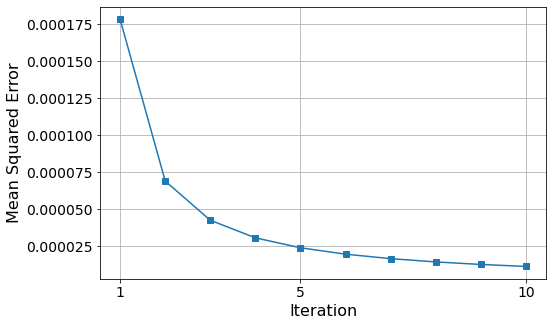

[0.00017802663849623727, 6.908337577632964e-05, 4.264918795901542e-05, 3.08093373839645e-05, 2.4103365951263002e-05, 1.9790137787422306e-05, 1.678402033185103e-05, 1.4569506780427382e-05, 1.2870532458156586e-05, 1.152596827526769e-05]


In [9]:
analysis_dict = {"batch_particle_connection": {"connect": False,
                                               "update_all": False}}
final_params, loss_evolution, loss_evolution_single_dict, batch_particle_dict = enkf_linear_inverse_problem(setting_dict,
                                                                                                            analysis_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       save = None)
print(loss_evolution[-10:])

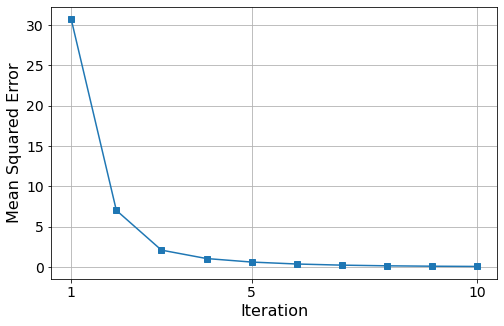

[30.72655103198794,
 7.012264240472735,
 2.0726250016031016,
 1.0271252070203365,
 0.5892989512720713,
 0.3479207498170358,
 0.2070876227299132,
 0.12386227378125697,
 0.0745753195633184,
 0.04537534619661931]

In [10]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 10,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       save = None)
loss_evolution[-10:]

## Modell:
$Ax=y + \eta$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch), $\eta\sim\mathscr{N}(0,\Gamma)$.

$x$ wird gesucht.

In [11]:
A = np.random.uniform(size = (10000, 50))
x = np.random.uniform(size = (A.shape[1], ))

In [12]:
def model_func(x):
    return np.dot(A, x)

In [13]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [14]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 10,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }

In [15]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)

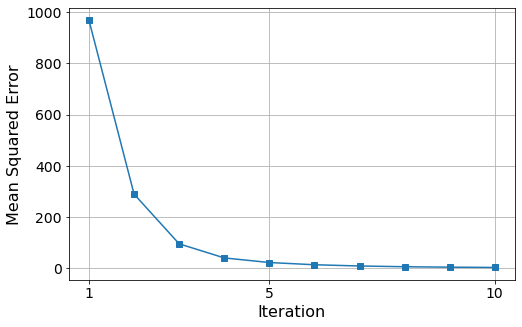

[968.329568644149,
 288.6308761599043,
 94.38224449850807,
 39.319126499133915,
 21.26541185638574,
 12.61735252013598,
 7.739751145073642,
 4.8466280482254795,
 3.1032673980958667,
 2.0470083424443053]

In [17]:
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       save = None)
loss_evolution[-10:]